# Chapter 3.1 Softmax


- Softmax
  - softmax的目的：对于分类问题，我们通常用离散值来表示类别，虽然我们仍然可以用回归模型进行建模，将预测值近似到类别的离散值（比如三个类别的离散值分别是1，2和3，那么我们可以用回归模型将预测值近似到1，2和3来完成分类任务），但这样通常会影响到分类质量，因此我们考虑适合**离散输出的模型**
  - softmax也是一个全连接层，其回归的输出值个数为类别数。softmax将输出层的输出当作是类别i的置信度，再通过softmax函数将各置信度归化成一个概率分布，最大的为模型认为的类别。
- 交叉熵损失函数
  - 使用softmax运算后可以更方便地与离散标签计算误差
  - 可以用线性回归的损失函数，比如平方损失，但是对于分类任务，我们不必要求预测类别的概率为1，只需要相对其他概率要更高即可，所以我们可以换一种思路，对整个类别的概率分布进行对比，将label看作一各true类概率为1，其余为0的one-hot分布，度量模型输出与label分布之间的差异，这时候就可以用到信息轮中的交叉熵损失函数。

## Image Classification Dataset-Fashion-MNIST    

- torchvision
  - torchvision.datasets: 加载数据/数据集
  - torchvision.models: 常用的模型结构/预训练模型
  - torchvision.transforms: 常用图片变换，比如裁剪，旋转等
  - torchvision.utils: 一些有用的方法
- Fashion-MNIST是一个10类服饰分类数据集，之后章节里将使用它来检验不同算法的表现。
  - 我们将高和宽分别为h和w像素的图像的形状记为h×w,h×w或(h，w)。

- the process of obtaining Fashion-MNIST dataset and loading it is integrated in **d2lzh_pytorch.load_data_fashion_mnist**

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import time
import sys
import matplotlib.pyplot as plt
import d2lzh_pytorch as d2l

- 一些细节
  - transform = transforms.ToTensor()使所有数据转换为Tensor，如果不进行转换则返回的是PIL图片。transforms.ToTensor()将尺寸为 (H x W x C) 且数据位于[0, 255]的PIL图片或者数据类型为np.uint8的NumPy数组转换为尺寸为(C x H x W)且数据类型为torch.float32且位于[0.0, 1.0]的Tensor
    - 自动归一化且转化为tensor
    - 注意： 由于像素值为0到255的整数，所以刚好是uint8所能表示的范围，包括transforms.ToTensor()在内的一些关于图片的函数就默认输入的是uint8型，若不是，可能不会报错但可能得不到想要的结果。所以，如果用像素值(0-255整数)表示图片数据，那么一律将其类型设置成uint8，避免不必要的bug。 
  - feature的尺寸是C\*H\*W，即通道数\*高\*宽，通道数为1代表灰度图像
  - Fashion-MNIST中一共包括了10个类别，分别为t-shirt（T恤）、trouser（裤子）、pullover（套衫）、dress（连衣裙）、coat（外套）、sandal（凉鞋）、shirt（衬衫）、sneaker（运动鞋）、bag（包）和ankle boot（短靴）。以下函数可以将数值标签转成相应的文本标签。

In [3]:
# obtain the dataset
mnist_train = torchvision.datasets.FashionMNIST(root='/Users/yanzheyuan/coding/dataset_pytorch/',\
                                               train=True, download=True, transform=transforms.ToTensor())
mnist_test = torchvision.datasets.FashionMNIST(root='/Users/yanzheyuan/coding/dataset_pytorch/',\
                                               train=False, download=True, transform=transforms.ToTensor())
print(type(mnist_train))
print(len(mnist_train),len(mnist_test))

feature, label = mnist_train[0]
print(feature.shape, label)   

Extracting /Users/yanzheyuan/coding/dataset_pytorch/FashionMNIST/raw/train-images-idx3-ubyte.gz to /Users/yanzheyuan/coding/dataset_pytorch/FashionMNIST/raw


Extracting /Users/yanzheyuan/coding/dataset_pytorch/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /Users/yanzheyuan/coding/dataset_pytorch/FashionMNIST/raw


Extracting /Users/yanzheyuan/coding/dataset_pytorch/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /Users/yanzheyuan/coding/dataset_pytorch/FashionMNIST/raw




Extracting /Users/yanzheyuan/coding/dataset_pytorch/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /Users/yanzheyuan/coding/dataset_pytorch/FashionMNIST/raw
Processing...
Done!
<class 'torchvision.datasets.mnist.FashionMNIST'>
60000 10000
torch.Size([1, 28, 28]) 9


/Users/software/anaconda/anaconda3/envs/pytorch_env/lib/python3.7/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1607370126481/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
# this function has been integrated to d2lzh_pytorch
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

# define a function that can draw multiple images and labels in a line
def show_fashion_mnist(images, labels):
    d2l.use_svg_display() # draw a svg pic
    _, figs = plt.subplots(1, len(images), figsize=(12,12)) # '_' stands for a variable that we don't use, just ignore it.
    for f, img, lbl in zip(figs, images, labels):
        print(img.size())
        print(img.view((28,28)).size())
        f.imshow(img.view((28,28)).numpy())
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
    plt.show()




torch.Size([1, 28, 28])
torch.Size([28, 28])
torch.Size([1, 28, 28])
torch.Size([28, 28])
torch.Size([1, 28, 28])
torch.Size([28, 28])
torch.Size([1, 28, 28])
torch.Size([28, 28])
torch.Size([1, 28, 28])
torch.Size([28, 28])
torch.Size([1, 28, 28])
torch.Size([28, 28])
torch.Size([1, 28, 28])
torch.Size([28, 28])
torch.Size([1, 28, 28])
torch.Size([28, 28])
torch.Size([1, 28, 28])
torch.Size([28, 28])
torch.Size([1, 28, 28])
torch.Size([28, 28])


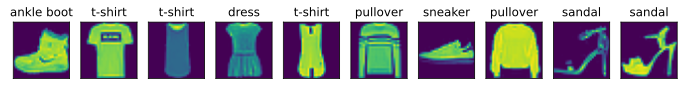

In [5]:
X,y = [], []
for i in range(10):
    X.append(mnist_train[i][0])
    y.append(mnist_train[i][1])
show_fashion_mnist(X,get_fashion_mnist_labels(y))

In [6]:
# obtain a batch using DataLoader

batch_size = 256
if sys.platform.startswith('win'):
    num_workers = 0  # 0 stands for no extra progress needed to load data
else:
    num_workers=4
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=True, num_workers=num_workers)

# start loading
start = time.time()
for X,y in train_iter:
    continue
print('%.2f sec' % (time.time()-start))


1.52 sec


## Softmax from scratch

In [28]:
import d2lzh_pytorch as d2dl
import torch
import torchvision
import numpy as np
import sys

- 一些细节：
  - torch.sum()函数，dim=0即返回一行，keepdim=True即结果保持原先的形式
  - torch.gather()中的dim=1代表对行做dimension revalue，每行的所有列，按照y的值所代表的index的值赋值。比如y为[0，2]，第一行的所有列都是这一行的第一个值，第二行的所有列都是第二行的第三个值。
  - 对torch.argmax函数，dim参数的定义是dimension reduction，意思是若dim=1，行这个维度会消失，若要消失，我们就得将每一列的所有行进行argmax得出最大值，最后返回一个行，值为最大的index。相等条件判断式(y_hat.argmax(dim=1) == y)是一个类型为ByteTensor的Tensor，我们用float()将其转换为浮点Tensor。
  - 在net，forward的时候，由于X的输入是（batch_size,1，28，28），需要变换形式到（batch_size,728）才能够与W想乘（在d2dl中有一个flatten层起到这个作用，但我们在实际上用pytorch的时候还是需要自己调整）
- 评价函数**evaluate_accuracy**，训练函数**train_ch3**已封装到d2dl中

epoch: 1, loss:0.7862, train acc: 0.750, test acc: 0.794
epoch: 2, loss:0.5711, train acc: 0.814, test acc: 0.812
epoch: 3, loss:0.5259, train acc: 0.826, test acc: 0.820
epoch: 4, loss:0.5014, train acc: 0.832, test acc: 0.824
epoch: 5, loss:0.4855, train acc: 0.837, test acc: 0.827


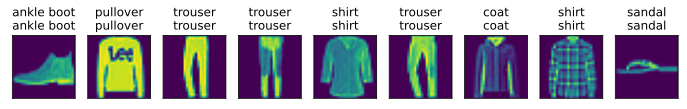

In [30]:
# Data Loader
batch_size = 256
train_iter, test_iter = d2dl.load_data_fashion_mnist(batch_size,root='/Users/yanzheyuan/coding/dataset_pytorch/')
num_inputs = 784
num_outputs = 10

# initialization
W = torch.tensor(np.random.normal(0,0.01,(num_inputs,num_outputs)),dtype=torch.float32)
b = torch.zeros(num_outputs, dtype=torch.float32)
W.requires_grad_(True)
b.requires_grad_(True)

# Define Model
def softmax(X):
    y = torch.exp(X) / torch.exp(X).sum(dim=1,keepdim=True)
    return y

def net(X):
    return softmax(torch.mm(X.view(-1,num_inputs),W)+b)  # there is a reshape

def cross_entropy(y_hat, y):
    return -torch.log(y_hat.gather(1,y.view(-1,1)))

def accuracy(y_hat, y):
    return (torch.argmax(y_hat,1)==y).float().mean().item()  # y is a column, so ==

def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X,y in data_iter:
        acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
        n += y.shape[0]
    return acc_sum/n  # return the accuracy for a batch
    
# Train Model
num_epochs = 5
lr = 0.1
def train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, params=None, lr=None, optimizor=None): 
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            y_hat = net(X)
            l = loss(y_hat,y).sum()
            
            # set gradient to zero
            if optimizor is not None:
                optimizor.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
            
            l.backward()
            if optimizor is None:
                d2dl.sgd(params,lr,batch_size)
            else: 
                optimizor.step()
                
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(1)==y).sum().item()
            #if epoch == 1:
            #    print((y_hat.argmax(1)==y).float().dtype)
            n += y.shape[0]
        
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch: %d, loss:%.4f, train acc: %.3f, test acc: %.3f' %(epoch+1,train_l_sum/n,train_acc_sum/n,test_acc))
                    
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, batch_size, [W, b], lr)          

# Predict
X, y = iter(test_iter).next()

true_labels = d2dl.get_fashion_mnist_labels(y.numpy())
pred_labels = d2dl.get_fashion_mnist_labels(net(X).argmax(1).numpy())
titles = [true + '\n' + pred for true, pred in zip(true_labels, pred_labels)]

d2dl.show_fashion_mnist(X[0:9], titles[0:9])
    

## Softmax

In [16]:
import torch
from torch import nn
from torch.nn import init
import numpy as np
import sys
from torch import optim as optim

import d2lzh_pytorch as d2dl


- 一些细节：
  - FlattenLayer解决上一节的img维度转换问题，已经封装在d2dl
  - 到现在，在img classification fashion mnist中，已经封装的函数有：
    - d2dl.load_data_fashion_mnist
    - d2dl.FlattenLayer
    - d2dl.train_ch3
    - d2dl.get_fashion_mnist_labels：输入数字label返回label的文字
    - d2dl.show_fashion_mnist：输入img和label画图 
  - 不要忘了init参数
  - 

In [19]:
# Hyperparameter
num_epochs = 5
lr = 0.1
num_inputs = 784
num_outputs = 10
batch_size = 256

# Load Data
train_iter, test_iter = d2dl.load_data_fashion_mnist(batch_size,root='/Users/yanzheyuan/coding/dataset_pytorch/')

# Define Model
class FlattenLayer(nn.Module):
    def __init__(self):
        super(FlattenLayer,self).__init__()
    def forward(self, x):
        return x.view(x.shape[0], -1)

class LinearNet(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(LinearNet,self).__init__()
        self.linear = nn.Linear(num_inputs,num_outputs)
        self.flatten = d2dl.FlattenLayer()
    def forward(self, x):
        y = self.linear(self.flatten(x))
        return y

net = LinearNet(num_inputs,num_outputs)
print(net)

loss_func = nn.CrossEntropyLoss()
optimizor = optim.SGD(net.parameters(),lr)

# initialize the parameters
init.constant_(net.linear.bias, val=0)
init.normal_(net.linear.weight, mean=0, std=0.01)

# Train Model
d2dl.train_ch3(net,train_iter,test_iter,loss_func,num_epochs,batch_size,None,None,optimizor)
    

LinearNet(
  (linear): Linear(in_features=784, out_features=10, bias=True)
  (flatten): FlattenLayer()
)
epoch 1, loss 0.0031, train acc 0.746, test acc 0.786
epoch 2, loss 0.0022, train acc 0.813, test acc 0.803
epoch 3, loss 0.0021, train acc 0.827, test acc 0.811
epoch 4, loss 0.0020, train acc 0.832, test acc 0.815
epoch 5, loss 0.0019, train acc 0.837, test acc 0.823
